In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [8]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    if orient=='x':
        sob_val=cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    if orient=='y':
        sob_val=cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel)        
    # Apply threshold
    abs_sob=np.absolute(sob_val)
    norm_sobel=np.uint8(abs_sob*255/np.max(abs_sob))
    grad_binary=np.zeros_like(norm_sobel)
    grad_binary[(norm_sobel>=thresh[0])&(norm_sobel<=thresh[1])]=1
    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    gray=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    sob_x=cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sob_y=cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel) 
    abs_sob=np.sqrt((sob_x**2)+(sob_y**2))
    norm_sob=np.uint8(abs_sob*255/np.max(abs_sob))
    mag_binary=np.zeros_like(norm_sob)
    mag_binary[(norm_sob>=mag_thresh[0]) & (norm_sob<=mag_thresh[1])]=1
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    gray=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    sobel_x=cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobel_y=cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel)
    sobelx_abs=np.absolute(sobel_x)
    sobely_abs=np.absolute(sobel_y)
    gradient_dir=np.arctan2(sobely_abs,sobelx_abs)
    dir_binary=np.zeros_like(gradient_dir)
    dir_binary[(gradient_dir>=thresh[0])&(gradient_dir<=thresh[1])]=1
    return dir_binary



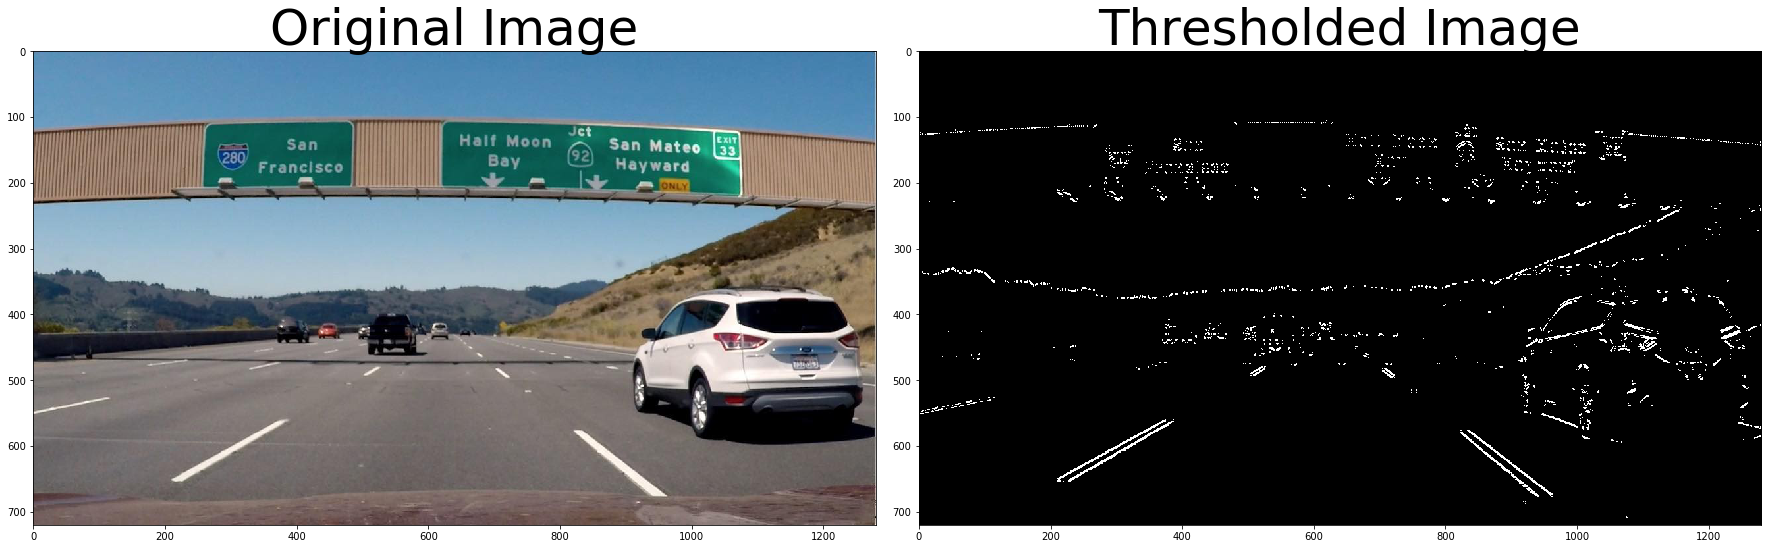

In [134]:
# Read in an image
image = mpimg.imread('signs_vehicles_xygrad.jpg')

# Choose a Sobel kernel size
ksize = 7 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(45, 150))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(85, 255))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7 ,1.3))

combined = np.zeros_like(dir_binary)
combined[((gradx ==1) & (grady ==1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1 
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Thresholded Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)